In [3]:
import pandas as pd
#import pandas.rpy.common as com
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from itertools import cycle
import numpy as np
from IPython.display import FileLink

In [4]:
%load_ext rpy2.ipython
%matplotlib inline

In [5]:
sample_df=pd.read_csv("data/sample_data.csv")
sample_df.rename(columns={"sample" : "sample_id"}, inplace=True)
sample_df.head()

,Sample_number,96 Well Plate Location,Sample Amount,sample_id,Genus Species,Sample Type,star,location
0,1,P1 - E12,1 mL,CF1_CF,Pentaceraster spp.,CF,star,Australia
1,2,P1 - F12,1 mL,CF2_CF,Pentaceraster spp.,CF,star,Australia
2,3,P1 - A1,0.1145 g,X8106_PC,Anthenea crassa,PC,star,Australia
3,4,P2 - A1,2 mL,X8532_CF,Anthenea crassa,CF,star,Australia
4,5,P1 - B1,0.109 g,X8533_TF,Anthenea crassa,TF,star,Australia


In [6]:
otu_df = pd.read_csv("data/EC_table.noMC.csv", index_col="seq_id")
otu_df = otu_df.stack().to_frame("count").reset_index()
otu_df = otu_df.rename(columns={"seq_id" : "OTU", "level_1" : "sample_id"})
#all_otus = pd.Series(otu_df["OTU"].unique())

sample_sums=otu_df.groupby("sample_id")["count"].sum().to_frame().reset_index()
samples_less_than_1000=sample_sums[sample_sums["count"]<1000]["sample_id"].values
otu_df=otu_df[~otu_df["sample_id"].isin(samples_less_than_1000)]

otu_df = otu_df.set_index("sample_id").join(sample_df.set_index("sample_id")).reset_index()

otu_df=otu_df[otu_df["star"]=="star"]
otu_df["count"] = otu_df.groupby("sample_id")["count"].transform(lambda x: x / x.sum())
otu_df.head()

,sample_id,OTU,count,Sample_number,96 Well Plate Location,Sample Amount,Genus Species,Sample Type,star,location
0,C10_CF,Sequence.1,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
1,C10_CF,Sequence.2,0.014930,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
2,C10_CF,Sequence.3,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
3,C10_CF,Sequence.4,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
4,C10_CF,Sequence.5,0.084101,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington


In [7]:
N = 60

top_N_otus_mean = (
    otu_df
        .groupby(["OTU"], as_index=False)["count"]
        .mean()
        .sort_values("count", ascending=False)
        #.groupby("Sample Type")
        .head(N)
)["OTU"].unique()

top_N_otus_mean

array(['Sequence.4', 'Sequence.6', 'Sequence.5', 'Sequence.12',
       'Sequence.9', 'Sequence.8', 'Sequence.2', 'Sequence.24',
       'Sequence.1', 'Sequence.13', 'Sequence.16', 'Sequence.17',
       'Sequence.21', 'Sequence.19', 'Sequence.11', 'Sequence.18',
       'Sequence.14', 'Sequence.36', 'Sequence.44', 'Sequence.30',
       'Sequence.41', 'Sequence.26', 'Sequence.20', 'Sequence.23',
       'Sequence.37', 'Sequence.39', 'Sequence.54', 'Sequence.43',
       'Sequence.48', 'Sequence.29', 'Sequence.33', 'Sequence.35',
       'Sequence.25', 'Sequence.57', 'Sequence.56', 'Sequence.22',
       'Sequence.59', 'Sequence.38', 'Sequence.34', 'Sequence.83',
       'Sequence.7', 'Sequence.66', 'Sequence.49', 'Sequence.108',
       'Sequence.47', 'Sequence.65', 'Sequence.42', 'Sequence.63',
       'Sequence.46', 'Sequence.61', 'Sequence.69', 'Sequence.60',
       'Sequence.82', 'Sequence.40', 'Sequence.58', 'Sequence.100',
       'Sequence.122', 'Sequence.70', 'Sequence.88', 'Sequence.202']

In [70]:
otu_top_N_df = otu_df[otu_df['OTU'].isin(top_N_otus_mean)]
otu_top_N_df.head()

,sample_id,OTU,count,Sample_number,96 Well Plate Location,Sample Amount,Genus Species,Sample Type,star,location
0,C10_CF,Sequence.1,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
1,C10_CF,Sequence.2,0.014930,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
3,C10_CF,Sequence.4,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
4,C10_CF,Sequence.5,0.084101,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
5,C10_CF,Sequence.6,0.071439,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington


In [71]:
%Rpush otu_top_N_df

In [100]:
%%R
tax_df = read.csv("data/tax_table.csv") %>% 
    rename(OTU = seq_id) %>%
    select(OTU, Rank3, Rank4, Rank5,Rank6)
tax_df %>% head

            OTU               Rank3             Rank4
1    Sequence.1          Mollicutes Entomoplasmatales
2   Sequence.10 Gammaproteobacteria   Alteromonadales
3  Sequence.100 Alphaproteobacteria     Rickettsiales
4 Sequence.1000         Bacteroidia     Bacteroidales
5 Sequence.1001    Planctomycetacia  Planctomycetales
6 Sequence.1002 Alphaproteobacteria   Rhodobacterales
                             Rank5                   Rank6
1 Entomoplasmatales Incertae Sedis Candidatus Hepatoplasma
2                Psychromonadaceae            Psychromonas
3                   Rickettsiaceae              uncultured
4               Porphyromonadaceae              uncultured
5                Planctomycetaceae            Planctomyces
6                 Rhodobacteraceae                    <NA>


In [142]:
%%R
tree.full = ape::read.tree("data/variants.tree")
tip_otus = tree.full$tip.label

head(tip_otus)

[1] "Sequence.5644" "Sequence.6171" "Sequence.6526" "Sequence.4250"
[5] "Sequence.7084" "Sequence.9572"


In [74]:
%%R
row_order = tip_otus[tip_otus %in% otu_top_N_df$OTU]

otu_top_N_df$OTU_ordered = factor(otu_top_N_df$OTU, levels=row_order)

otu_top_N_df_w_tax = otu_top_N_df %>% left_join(tax_df) 

row_order

/home/elliot/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = "OTU"

  warnings.warn(x, RRuntimeWarning)


 [1] "Sequence.7"   "Sequence.41"  "Sequence.16"  "Sequence.36"  "Sequence.8"  
 [6] "Sequence.1"   "Sequence.57"  "Sequence.65"  "Sequence.38"  "Sequence.12" 
[11] "Sequence.122" "Sequence.23"  "Sequence.29"  "Sequence.49"  "Sequence.58" 
[16] "Sequence.47"  "Sequence.100" "Sequence.44"  "Sequence.54"  "Sequence.202"
[21] "Sequence.56"  "Sequence.30"  "Sequence.5"   "Sequence.39"  "Sequence.35" 
[26] "Sequence.82"  "Sequence.17"  "Sequence.63"  "Sequence.43"  "Sequence.19" 
[31] "Sequence.69"  "Sequence.11"  "Sequence.22"  "Sequence.26"  "Sequence.88" 
[36] "Sequence.34"  "Sequence.66"  "Sequence.108" "Sequence.24"  "Sequence.59" 
[41] "Sequence.2"   "Sequence.83"  "Sequence.70"  "Sequence.25"  "Sequence.37" 
[46] "Sequence.21"  "Sequence.6"   "Sequence.60"  "Sequence.46"  "Sequence.13" 
[51] "Sequence.20"  "Sequence.42"  "Sequence.18"  "Sequence.9"   "Sequence.61" 
[56] "Sequence.33"  "Sequence.40"  "Sequence.14"  "Sequence.4"   "Sequence.48" 


In [75]:
%%R
library(dplyr)
library(ggplot2)

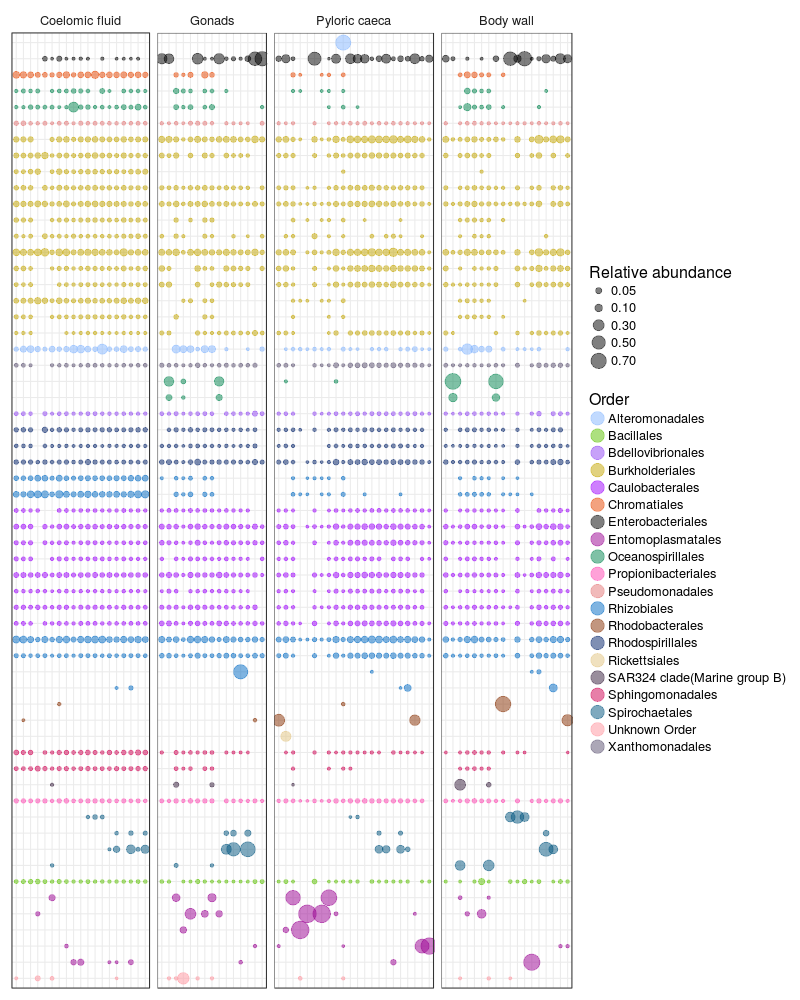

In [141]:
%%R -w 800 -h 1000
#9D00FD
colors = c("#84b6ff",
"#5dc100",
"#8f44f3",
"#c3a600",
"#9D00FD",
"#e74700",
"#000000",
"#990091",
"#00834e",
"#ff44b1",
"#E37777",
"#006bc3",
"#852f00",
"#002168",
"#e1c380",
"#341d3a",
"#cf0052",
"#00557e",
"#ff939e",
"#5b5070",
"#ffacd3")

#77DBE3
#4982ff
Tissuenames = c(
                    `PC` = "Pyloric caeca",
                    `G` = "Gonads",
                    `CF` = "Coelomic fluid",
                    `TF` = "Body wall"
                    )

p = ggplot(na.omit(otu_top_N_df_w_tax) %>% filter(count > 0), 
           aes(x = sample_id, 
               y = OTU_ordered, 
               size = count,
               color = Rank4))

p = p + facet_grid(~Sample.Type, scales = 'free_x', space = 'free_x',labeller = as_labeller(Tissuenames))

p = p + geom_point(alpha = 0.5)

p = p + theme_bw(base_size = 16)

p = p + theme(
    strip.background = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.title.x=element_blank(),
    axis.ticks = element_blank(),
    axis.title.y=element_blank()
)

p = p + scale_color_manual(values = colors) + labs( size = "Relative abundance" )

p = p + guides(color = guide_legend(override.aes = list(size=6),ncol = 1,title = "Order"))

p = p + scale_size(range = c(1, 8), breaks = c(0, 
                                               0.05, 
                                               0.1,
                                               0.3,
                                               0.5,
                                               0.7,
                                               1.0))

p

In [7]:
%%R
tree.full = ape::read.tree("data/variants.tree")
tip_otus = tree.full$tip.label

In [8]:
%Rpull tip_otus
tip_otus = pd.Series(tip_otus)

In [9]:
COLORS=\
["#84b6ff",
"#5dc100",
"#8f44f3",
"#c3a600",
"#4982ff",
"#e74700",
"#01dd99",
"#990091",
"#00834e",
"#ff44b1",
"#f20042",
"#006bc3",
"#852f00",
"#002168",
"#e1c380",
"#341d3a",
"#cf0052",
"#00557e",
"#ff939e",
"#5b5070",
"#ffacd3"]

In [17]:
def get_tree_df(tree_fn, to_remove=None):
    %Rpush tree_fn
    %R -n tree = ape::read.tree(tree_fn)
    if to_remove is not None:
        %Rpush to_remove
        %R -n tree = ape::drop.tip(tree, to_remove, rooted = TRUE)
    %R -n tree_dfs = phyloseq::tree_layout(tree, ladderize = "right")
    %R -n edge_df = data.frame(tree_dfs$edgeDT)
    %R -n vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    edge_df.y = edge_df.y - 0.5
    vert_df.vmax = vert_df.vmax - 0.5
    vert_df.vmin = vert_df.vmin - 0.5
    return edge_df, vert_df

def get_tax_strip_info(edge_df):
    tip_df=e[e.OTU!="NA"]
    max_right=tip_df.xright.max()*1.15
    buffer = max_right * 0.01
    verts = tip_df.apply(lambda row: [(row["xright"] + buffer, row["y"] - 0.5), 
                                      (row["xright"] + buffer, row["y"] + 0.5),
                                      (max_right, row["y"] + 0.5), 
                                      (max_right, row["y"] - 0.5)], axis = 1).values
    return verts

def get_tax_strip_colors(edge_df, tax_df, color_rank="Rank4"):
    tip_df=e[e.OTU!="NA"]
    OTUs=tip_df["OTU"]
    taxa=tax_df[tax_df["OTU"].isin(OTUs)][color_rank].unique()
    color_d = dict([(taxon, color) for taxon, color in zip(taxa, cycle(COLORS))])
    color_d[np.nan] = "#555555"
    tmp=tip_df.set_index("OTU").join(tax_df.set_index("OTU"))
    tmp.reset_index(inplace=True)
    tmp["color"]=tmp[color_rank].map(color_d)
    return tmp[["OTU","color", color_rank]], color_d

def get_otus_to_remove(rank, keepers, tax_df):
    to_remove=tax_df[~tax_df[rank].isin(keepers)]["OTU"].values
    return to_remove

def get_heatmap_data(edge_df, otu_df, sample_df, tissue_types):
    tip_y_df=e[e.OTU!="NA"][["OTU","y"]].set_index("OTU")
    otu_df_plot=otu_df.set_index("sample_id").join(sample_df.set_index("sample_id")).reset_index()
    otu_df_plot=otu_df_plot[otu_df_plot["Sample Type"].isin(tissue_types)]
    matrix_df=otu_df_plot.pivot_table(index="OTU", values="count", columns="sample_id").join(tip_y_df).dropna()
    matrix_df.sort_values("y", inplace=True)
    matrix_df=matrix_df.drop("y",1)
    hm_top, hm_right = matrix_df.as_matrix().shape
    return  hm_top, hm_right, matrix_df
    
def make_heatmap():
    pass

In [73]:
#otu_df[otu_df["Sample Type"]]

In [121]:
sample_df.head()

,Sample_number,96 Well Plate Location,Sample Amount,sample_id,Genus Species,Sample Type,star,location
0,1,P1 - E12,1 mL,CF1_CF,Pentaceraster spp.,CF,star,Australia
1,2,P1 - F12,1 mL,CF2_CF,Pentaceraster spp.,CF,star,Australia
2,3,P1 - A1,0.1145 g,X8106_PC,Anthenea crassa,PC,star,Australia
3,4,P2 - A1,2 mL,X8532_CF,Anthenea crassa,CF,star,Australia
4,5,P1 - B1,0.109 g,X8533_TF,Anthenea crassa,TF,star,Australia


In [122]:
otu_df.head()

,sample_id,OTU,count,Sample_number,96 Well Plate Location,Sample Amount,Genus Species,Sample Type,star,location
0,C10_CF,Sequence.1,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
1,C10_CF,Sequence.2,0.014930,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
2,C10_CF,Sequence.3,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
3,C10_CF,Sequence.4,0.000000,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington
4,C10_CF,Sequence.5,0.084101,42,P2 - F2,2 mL,Hippasteria spinosa,CF,star,Washington


In [10]:
N = 30

top_N_otus_max = (
    otu_df
        .sort_values("count", ascending=False)
        .groupby(["OTU", "Sample Type"], as_index=False)
        .first()
        .sort_values("count", ascending=False)
        .groupby("Sample Type")
        .head(N)
)["OTU"].unique()

top_N_otus_max

array(['Sequence.8', 'Sequence.36', 'Sequence.16', 'Sequence.41',
       'Sequence.24', 'Sequence.1', 'Sequence.54', 'Sequence.48',
       'Sequence.12', 'Sequence.4', 'Sequence.56', 'Sequence.23',
       'Sequence.44', 'Sequence.7', 'Sequence.49', 'Sequence.57',
       'Sequence.38', 'Sequence.2', 'Sequence.100', 'Sequence.33',
       'Sequence.166', 'Sequence.174', 'Sequence.6', 'Sequence.108',
       'Sequence.178', 'Sequence.9', 'Sequence.202', 'Sequence.156',
       'Sequence.176', 'Sequence.11', 'Sequence.14', 'Sequence.215',
       'Sequence.5', 'Sequence.32', 'Sequence.265', 'Sequence.151',
       'Sequence.337', 'Sequence.27', 'Sequence.204', 'Sequence.268',
       'Sequence.206', 'Sequence.21', 'Sequence.18', 'Sequence.25',
       'Sequence.143', 'Sequence.182', 'Sequence.122', 'Sequence.311',
       'Sequence.65', 'Sequence.1094', 'Sequence.85', 'Sequence.13',
       'Sequence.26', 'Sequence.22', 'Sequence.173', 'Sequence.123',
       'Sequence.37', 'Sequence.238', 'Sequence

In [12]:
N = 60

top_N_otus_mean = (
    otu_df
        .groupby(["OTU"], as_index=False)["count"]
        .mean()
        .sort_values("count", ascending=False)
        #.groupby("Sample Type")
        .head(N)
)["OTU"].unique()

top_N_otus_mean

array(['Sequence.4', 'Sequence.6', 'Sequence.5', 'Sequence.12',
       'Sequence.9', 'Sequence.8', 'Sequence.2', 'Sequence.24',
       'Sequence.1', 'Sequence.13', 'Sequence.16', 'Sequence.17',
       'Sequence.21', 'Sequence.19', 'Sequence.11', 'Sequence.18',
       'Sequence.14', 'Sequence.36', 'Sequence.30', 'Sequence.26',
       'Sequence.44', 'Sequence.41', 'Sequence.20', 'Sequence.23',
       'Sequence.37', 'Sequence.39', 'Sequence.54', 'Sequence.43',
       'Sequence.48', 'Sequence.7', 'Sequence.29', 'Sequence.25',
       'Sequence.33', 'Sequence.35', 'Sequence.57', 'Sequence.22',
       'Sequence.56', 'Sequence.59', 'Sequence.38', 'Sequence.34',
       'Sequence.83', 'Sequence.66', 'Sequence.49', 'Sequence.108',
       'Sequence.47', 'Sequence.65', 'Sequence.42', 'Sequence.63',
       'Sequence.46', 'Sequence.61', 'Sequence.69', 'Sequence.60',
       'Sequence.40', 'Sequence.82', 'Sequence.58', 'Sequence.100',
       'Sequence.122', 'Sequence.88', 'Sequence.70', 'Sequence.109']

In [13]:
top_N_union = set(top_N_otus_mean).union(set(top_N_otus_max))
top_N_union = pd.Series(list(top_N_union))

In [14]:
print(top_N_otus_max.shape, top_N_otus_mean.shape, len(top_N_union))

((75,), (60,), 94)


In [15]:
tax_df=pd.read_csv("data/tax_table.csv")
tax_df.rename(columns={"seq_id" : "OTU"}, inplace=True)

In [18]:
#to_remove=get_otus_to_remove("Rank3", keepers=["Betaproteobacteria","Alphaproteobacteria"], 
#                             tax_df=tax_df)
to_remove = tip_otus[~tip_otus.isin(top_N_otus_mean)].values

e, v=get_tree_df("data/variants.tree", to_remove=to_remove)
OTU_position = e[e.OTU!="NA"][["OTU","y"]].sort_values("y")
verts=get_tax_strip_info(e)
color_rank = "Rank4"
vert_colors, color_d=get_tax_strip_colors(edge_df=e, tax_df=tax_df, color_rank=color_rank)
e.head()

,V1,V2,edge.length,OTU,xleft,xright,y,x,label
1,64,1,0.73252,Sequence.7,0.15492,0.88744,54.5,NaN,NA
2,68,2,0.00776,Sequence.41,0.47996,0.48772,50.5,NaN,NA
3,70,3,0.02586,Sequence.16,0.49821,0.52407,47.5,NaN,NA
4,70,4,0.00414,Sequence.36,0.49821,0.50235,48.5,NaN,NA
5,69,5,0.02523,Sequence.8,0.49806,0.52329,49.5,NaN,NA


In [19]:
v.head()

,V1,x,vmin,vmax,y,label
1,61,0.00000,39.142120,57.533203,48.837662,0.808
2,62,0.00014,55.566406,59.500000,NaN,NA
3,63,0.13903,53.507812,57.625000,NaN,NA
4,64,0.15492,52.515625,54.500000,NaN,NA
5,65,0.25096,51.531250,53.500000,NaN,NA


In [20]:
tissue_types=["CF","TF","PC","G"]
tissue_types_d={"CF" : "Coelomic Fluid", 
                "TF" : "Body Wall", 
                "PC" : "Pyloric Caeca", 
                "G" : "Gonads"}

In [21]:
import matplotlib
import copy
import matplotlib.patches as mpatches

([], [])

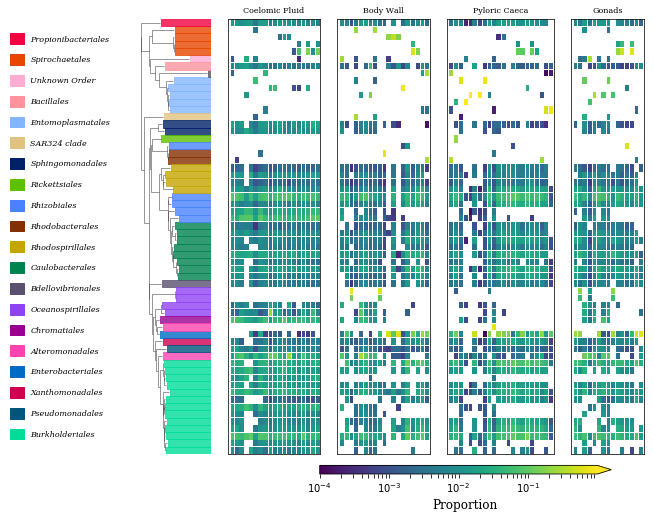

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, squeeze=True, 
                        gridspec_kw={"width_ratios" : [19*0.75,19,19,22,15]})
fig.set_size_inches((9,8))

ax = axs[0]

heatmap_axs = axs[1:]

vmin = otu_df[otu_df["count"]>0]["count"].quantile(0.033)
vmax = otu_df[otu_df["count"]>0]["count"].quantile(1)

ims=[]

for ax_hm, tissue_type in zip(heatmap_axs, tissue_types):
    hm_top, hm_right, matrix_df = get_heatmap_data(edge_df=e, 
                                                   otu_df=otu_df[["OTU","sample_id","count"]], 
                                                   sample_df=sample_df, 
                                                   tissue_types=[tissue_type])
    my_cmap = copy.copy(matplotlib.cm.viridis) # copy the default cmap. this the color scale 
    my_cmap.set_bad(color="#ffffff") ##making the background white
    im = ax_hm.pcolormesh(matrix_df.as_matrix(), edgecolors="#ffffff", linewidth = 0.003,
                 vmin=vmin, vmax=vmax,
                 cmap=my_cmap, 
                 #aspect="auto", 
                 #origin="upper", 
                 #interpolation="nearest",  
                 #extent = [0.5,hm_right,0.35,hm_top+0.35], 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    ims.append(im)
    ax_hm.set_frame_on(True)
    for spine in ax_hm.spines.values():
        spine.set_edgecolor('#151515')
    ax_hm.set_xticklabels([]); ax_hm.set_xticks([])
    ax_hm.set_yticklabels([]), ax_hm.set_yticks([])
    #ax_hm.set_ylim([-e.y.max()*0.05,e.y.max()*1.05])
    ax_hm.set_xlim((-0.5, matrix_df.shape[1]))
    ax_hm.set_title(tissue_types_d[tissue_type], fontdict={"family" : "serif", "size" : 8})
    
#cbar_ax, cbar_kw = matplotlib.colorbar.make_axes(heatmap_axs[-1], 
#                                                 shrink=2, 
#                                                 pad=0.15,
#                                                 orientation="horizontal",
#                                                 panchor=False)
cbar_ax = fig.add_axes([0.4,0.09,0.45,0.015])
cbar = fig.colorbar(ims[-3], cax=cbar_ax, orientation="horizontal", extend="max")
cbar.set_label(label="Proportion", fontdict={"family" : "serif", "size" : 12})
## change the font for the Relative Proportion to match other stuff
segments_h=[[(d.xleft, d.y),(d.xright, d.y)] for n,d in e.iterrows()]
segments_v=[[(d.x, d.vmin),(d.x, d.vmax)] for n,d in v.iterrows()]
lc_h = LineCollection(segments_h, linewidths=0.5, color="#353535")
lc_v = LineCollection(segments_v, linewidths=0.5, color="#353535")
ax.add_collection(lc_h)
ax.add_collection(lc_v)

legend_df = (
    vert_colors
        .set_index("OTU")
        .join(OTU_position.set_index("OTU"))
        .reset_index(drop=True)
        .sort_values("y", ascending=False)
        .drop("y", axis=1)
        .drop_duplicates()
)
patches = []
for i, row in legend_df.iterrows():
    taxon = row[color_rank]
    if pd.notnull(taxon):
        if taxon.startswith("SAR324 clade"):
            taxon = "SAR324 clade"
        patch = mpatches.Patch(color=row["color"], label=taxon)
        patches.append(patch)
lgd = ax.legend(handles=patches, 
          bbox_to_anchor=(-2, 0.5), 
          loc=6, 
          ncol=1, 
          frameon=False, 
          handlelength=1.7,
          handleheight=1.7,
          labelspacing=1.25,
          prop={"family" : "serif", "size" : 8, "style" : "italic"})

rect_collection = PolyCollection(verts, 
                                 alpha = 0.8, #sets the transparency of the lines
                                 lw = 0.9,
                                 color=[c for c in vert_colors.color])
ax.add_collection(rect_collection)

#ax.set_ylim([-e.y.max()*0.05,e.y.max()*1.05])
ax.set_xlim([-e.xright.max()*0.00, e.xright.max()*1.05])

ax.set_frame_on(False)
ax.set_xticklabels([]); ax.set_xticks([])
ax.set_yticklabels([]), ax.set_yticks([])

In [1]:
matrix_df.head()

NameError: name 'matrix_df' is not defined

In [67]:
np.arange(0.5,56.5) #+ np.zeros(matrix_df.shape) #.as_matrix()

array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
        27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
        36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
        45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
        54.5,  55.5])